In [1]:
import numpy as np
import torch 
from torchvision import datasets, transforms
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
model2 = ptcv_get_model("sepreresnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()
model2.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
model2 = model2.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified


In [4]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)
hessian_comp2 = hessian(model2, criterion, data=(inputs, targets), cuda=True)

/home/taebaek/anaconda3/envs/albef/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/torch/csrc/autograd/engine.cpp:976.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


In [5]:
# get the top1, top2 eigenvectors
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
top_eigenvalues2, top_eigenvector2 = hessian_comp2.eigenvalues(top_n=2)

In [6]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

/home/taebaek/anaconda3/envs/albef/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


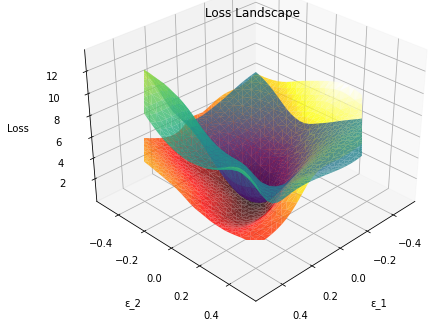

In [7]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams1 = np.linspace(-0.5, 0.5, 31).astype(np.float32)
lams2 = np.linspace(-0.5, 0.5, 31).astype(np.float32)

loss_list = []
loss_list2 = []

# create a copy of the model
model_perb1 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb1.eval()
model_perb1 = model_perb1.cuda()

model_perb2 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb2.eval()
model_perb2 = model_perb2.cuda()

model2_perb1 = ptcv_get_model("sepreresnet20_cifar10", pretrained=True)
model2_perb1.eval()
model2_perb1 = model2_perb1.cuda()

model2_perb2 = ptcv_get_model("sepreresnet20_cifar10", pretrained=True)
model2_perb2.eval()
model2_perb2 = model2_perb2.cuda()


for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_perb1, top_eigenvector[0], lam1)
        model_perb2 = get_params(model_perb1, model_perb2, top_eigenvector[1], lam2)
        loss_list.append((lam1, lam2, criterion(model_perb2(inputs), targets).item()))   
 
        model2_perb1 = get_params(model2, model2_perb1, top_eigenvector2[0], lam1)
        model2_perb2 = get_params(model2_perb1, model2_perb2, top_eigenvector2[1], lam2)
        loss_list2.append((lam1, lam2, criterion(model2_perb2(inputs), targets).item()))   

loss_list = np.array(loss_list)
loss_list2 = np.array(loss_list2)
                         
fig = plt.figure()
landscape = fig.gca(projection='3d')
landscape.plot_trisurf(loss_list[:,0], loss_list[:,1], loss_list[:,2],alpha=0.8, cmap='viridis')
                       #cmap=cm.autumn, #cmamp = 'hot')
landscape.plot_trisurf(loss_list2[:,0], loss_list2[:,1], loss_list2[:,2],alpha=0.8, cmap='hot')
                       #cmap=cm.autumn, #cmamp = 'hot')

landscape.set_title('Loss Landscape')
landscape.set_xlabel('ε_1')
landscape.set_ylabel('ε_2')
landscape.set_zlabel('Loss')

#z_min = min(min(loss_list[:,2]),min(loss_list2[:,2]))
#landscape.set_zlim(z_min, z_min+13)
landscape.view_init(elev=30, azim=45)
landscape.dist = 6
plt.show()